![Mars Panorama](mars.jpg)

# RedRank

#### A Bayesian Terraforming Mars player rating system using Microsoft TrueSkill

#### Kevin Beam

In [12]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

The game results for all games to date. This will be loaded dynamically from a Google Sheet in the future, but for now are recorded below.

In [13]:
game_data = [
    {'Steve': 121, 'Benjamin': 109.5, 'Todd': 98},
    {'Steve': 82, 'Matt': 70, 'Allis': 64, 'Todd': 61, 'Benjamin': 59},
    {'Todd': 80, 'Matt': 78, 'Benjamin': 74, 'Steve': 71},
    {'Todd': 74, 'Matt': 71, 'Allis': 71, 'Benjamin': 62, 'Steve': 48},
    {'Allis': 96, 'Benjamin': 93, 'Steve': 87},
    {'Allis': 99, 'Benjamin': 92, 'Steve': 92},
    {'Steve': 159, 'Todd': 130},
    {'Matt': 78, 'Todd': 64, 'Benjamin': 62, 'Steve': 60, 'Kevin': 48},
    {'Allis': 145, 'Todd': 115}
]

games = pd.DataFrame(game_data)
games.fillna('-')

,Allis,Benjamin,Kevin,Matt,Steve,Todd
0,-,109.5,-,-,121,98
1,64,59,-,70,82,61
2,-,74,-,78,71,80
3,71,62,-,71,48,74
4,96,93,-,-,87,-
5,99,92,-,-,92,-
6,-,-,-,-,159,130
7,-,62,48,78,60,64
8,145,-,-,-,-,115


Here we show the total score for each game, and a scatterplot of total game score by number of players in the game. Is there a correlation, or are total game scores distributed the same regardless of number of players? More data, please!

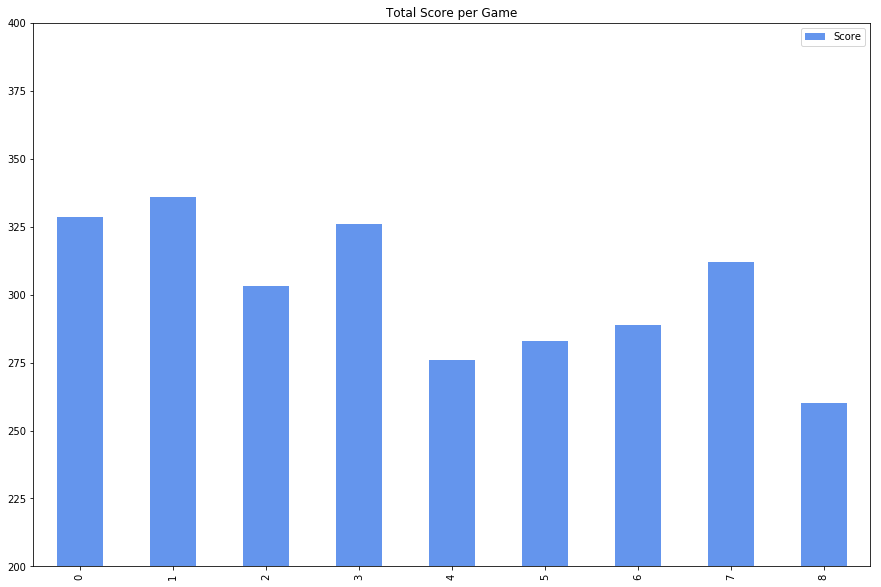

In [14]:
plt.figure()
pd.Series(games.sum(axis='columns'), name='Score')\
  .plot.bar(title='Total Score per Game', ylim=(200,400), color='cornflowerblue')
plt.legend(loc='best')

<Figure size 1080x720 with 0 Axes>

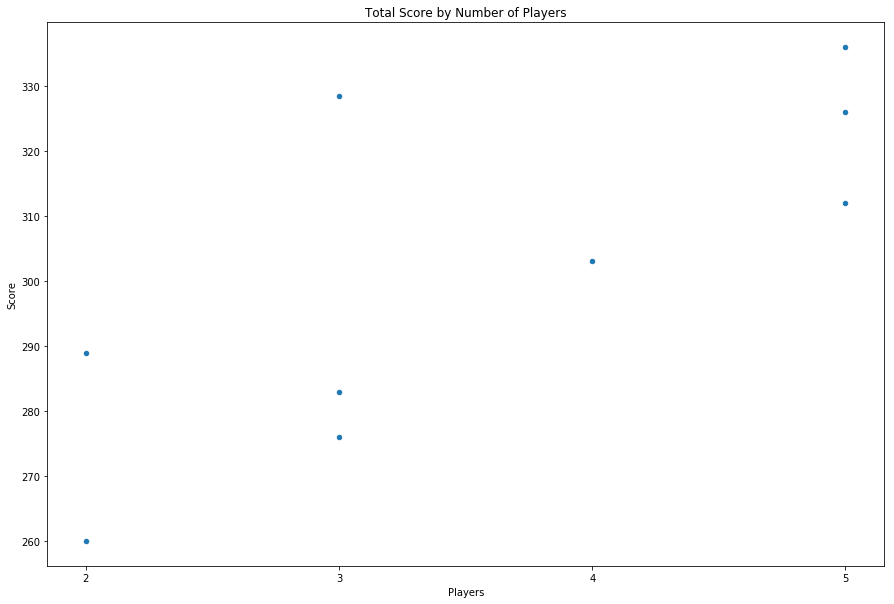

In [15]:
plt.figure()
pd.DataFrame({'Players': games.count(axis='columns').astype(np.uint8), 'Score': games.sum(axis='columns')})\
  .plot.scatter(x='Players', y='Score', title='Total Score by Number of Players', xticks=range(2, 6))

---

# TrueSkill

#### Use Microsoft TrueSkill to rate the players

---

In [16]:
import math
from functools import partial
from scipy.stats import norm
from trueskill import global_env, quality_1vs1, rate, setup, Rating, BETA
setup(backend='scipy')

trueskill.TrueSkill(mu=25.000, sigma=8.333, beta=4.167, tau=0.083, draw_probability=10.0%, backend='scipy')

In [17]:
ratings = {n: Rating() for n in games.columns}

In [18]:
def update_ratings(ratings, game):
    game = game.dropna()
    rating_groups = [(ratings[n],) for n in game.index]
    ranks = game.rank(ascending=False).values.astype(int)
    new_ratings = rate(rating_groups, ranks)
    for n, nr in zip(game.index, new_ratings):
        ratings[n] = nr[0]
        
games.apply(partial(update_ratings, ratings), axis='columns')

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
dtype: object

## TrueSkill ratings after all games

In [19]:
ratings

{'Allis': trueskill.Rating(mu=29.182, sigma=3.054),
 'Benjamin': trueskill.Rating(mu=21.708, sigma=2.388),
 'Kevin': trueskill.Rating(mu=15.136, sigma=5.569),
 'Matt': trueskill.Rating(mu=29.153, sigma=2.968),
 'Steve': trueskill.Rating(mu=21.022, sigma=2.431),
 'Todd': trueskill.Rating(mu=25.560, sigma=2.605)}

## Conservative estimate of player strength -- there is a 99% chance your rating is above this level

In [20]:
for n, r in ratings.items():
    print('{}: {:.4}'.format(n, r.mu - 3*r.sigma))

Allis: 20.02
Benjamin: 14.54
Kevin: -1.571
Matt: 20.25
Steve: 13.73
Todd: 17.74


## Player rating estimate curves
### Location of the peak indicates mean player strength estimate, width of curve is the estimate uncertainty

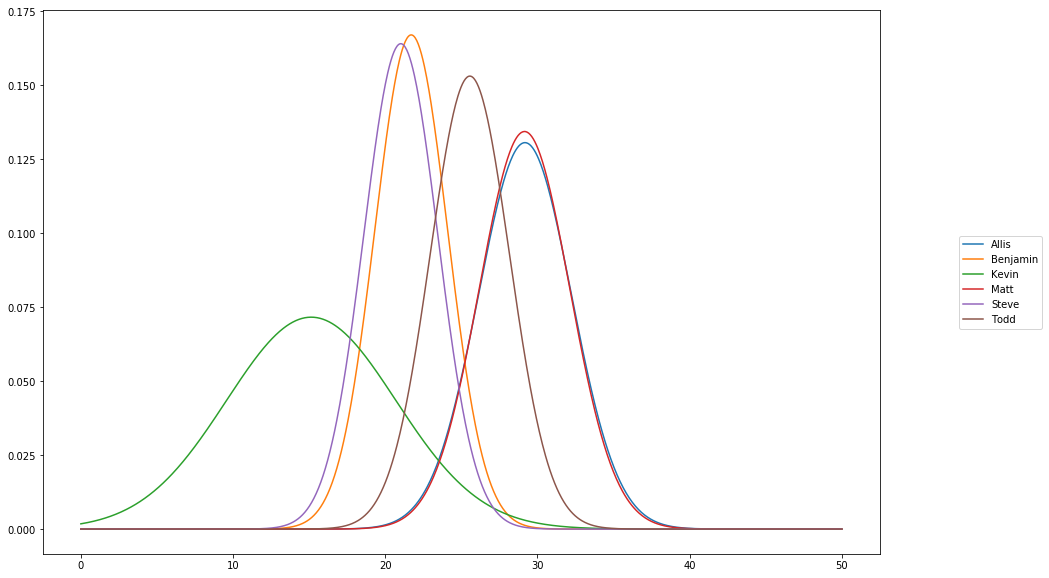

In [21]:
x = np.linspace(0,50,1000)
for n, r in ratings.items():
    plt.plot(x, norm.pdf(x, loc=r.mu, scale=r.sigma), label=n)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

## Pairwise expected match results based on player rating, which includes rating uncertainty

In [22]:
for n, r in ratings.items():
    print('------------------')
    print(n, r)
    for opp_n, opp_r in ratings.items():
        if n is opp_n:
            continue
        delta_mu = r.mu - opp_r.mu
        sum_sigma = r.sigma ** 2 + opp_r.sigma ** 2
        win_p = global_env().cdf(delta_mu / math.sqrt(2*BETA*BETA + sum_sigma))
        print('  vs {}: {:.1%} chance to win'.format(opp_n, win_p))

------------------
Allis trueskill.Rating(mu=29.182, sigma=3.054)
  vs Benjamin: 85.5% chance to win
  vs Kevin: 94.8% chance to win
  vs Matt: 50.2% chance to win
  vs Steve: 87.6% chance to win
  vs Todd: 69.4% chance to win
------------------
Benjamin trueskill.Rating(mu=21.708, sigma=2.388)
  vs Allis: 14.5% chance to win
  vs Kevin: 78.2% chance to win
  vs Matt: 14.4% chance to win
  vs Steve: 54.0% chance to win
  vs Todd: 28.8% chance to win
------------------
Kevin trueskill.Rating(mu=15.136, sigma=5.569)
  vs Allis: 5.2% chance to win
  vs Benjamin: 21.8% chance to win
  vs Matt: 5.2% chance to win
  vs Steve: 24.3% chance to win
  vs Todd: 11.0% chance to win
------------------
Matt trueskill.Rating(mu=29.153, sigma=2.968)
  vs Allis: 49.8% chance to win
  vs Benjamin: 85.6% chance to win
  vs Kevin: 94.8% chance to win
  vs Steve: 87.6% chance to win
  vs Todd: 69.4% chance to win
------------------
Steve trueskill.Rating(mu=21.022, sigma=2.431)
  vs Allis: 12.4% chance to 